In [13]:
import os
from dotenv import load_dotenv
import json
import pandas as pd
import ast
from openai import OpenAI
# from serpapi import Client as SerpApiClient
import requests
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

load_dotenv()

# 定义所需的环境变量
REQUIRED_VARS = [
    "OPENROUTER_API_KEY",
    "OPENROUTER_BASE_URL",
    "SERPER_API_KEY"
]

# 使用字典推导式加载配置，同时检查缺失项
config = {var: os.environ.get(var) for var in REQUIRED_VARS}
missing_vars = [var for var, value in config.items() if not value]

if missing_vars:
    raise ValueError(f"错误: 缺少必要的环境变量: {', '.join(missing_vars)}")

In [14]:
SERPER_API_KEY = config["SERPER_API_KEY"]

# Models
QUERY_GENERATOR_MODEL = "google/gemini-2.5-flash-lite" # 使用一个更经济的模型来生成查询
JUDGE_MODEL = "google/gemini-2.5-flash"              # 使用最强的模型来做裁判

# Files and Samples
INPUT_FILE = "experiment_1_auto_evaluated.csv"
OUTPUT_DETAILED_RESULTS_FILE = "experiment_2_detailed_results.csv"
OUTPUT_CHART_EFFECTIVENESS = "figure_3_query_effectiveness_rate.png"
OUTPUT_CHART_FAILURE_REASONS = "figure_4_failure_reason_analysis.png"
NUM_SAMPLES = 30 # 从实验一的结果中选取一部分进行这个更昂贵的实验

# --- Prompt Templates ---
REVISED_QUERY_GENERATION_PROMPT = """
You are an expert search engine user. Your primary task is to generate effective Google search queries to verify a given knowledge triple.

First, think step-by-step about what information is needed to verify the triple.
Then, generate up to 3 diverse and concise queries based on your thinking.

Knowledge Triple: {triple}

Your final output MUST be a JSON object with a single key "queries" containing a list of strings.
Example: {{"queries": ["when did Queen Victoria marry Prince Albert", "Queen Victoria Prince Albert wedding date"]}}
"""

JUDGE_PROMPT = """
You are a meticulous fact-checker. Your task is to determine if the provided "Search Snippets" contain enough information to confirm or refute the "Knowledge Triple".
You must base your decision *only* on the information within the snippets. Do not use your own internal knowledge.

- "confirm": The snippets directly state or strongly imply the triple is true.
- "refute": The snippets directly state or strongly imply the triple is false.
- "not_found": The snippets are irrelevant, ambiguous, or do not contain enough information to make a decision.

Knowledge Triple: {triple}
Search Snippets:
---
{snippets}
---

Respond in a JSON format with two keys: "decision" (one of "confirm", "refute", "not_found") and "reasoning" (a brief explanation).
"""

In [15]:
openai_client = OpenAI(
    api_key=config["OPENROUTER_API_KEY"], 
    base_url=config["OPENROUTER_BASE_URL"]
    )

In [16]:
def generate_queries_from_triple(triple: tuple) -> list:
    """
    Generates search queries from a triple with enhanced, robust parsing and debugging.
    """
    try:
        prompt = REVISED_QUERY_GENERATION_PROMPT.format(triple=str(triple))
        response = openai_client.chat.completions.create(
            model=QUERY_GENERATOR_MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
            response_format={"type": "json_object"}
        )
        content = response.choices[0].message.content

        # --- 关键修改 1: 打印原始输出 (让我们看看模型到底返回了什么) ---
        print(f"\n[DEBUG] Raw output for triple {triple}: {content}")

        # --- 关键修改 2: 更稳健的解析逻辑 ---
        if not content:
            print("[WARN] LLM returned empty content.")
            return []

        data = json.loads(content)
        
        # 检查解析后的数据是不是一个字典
        if not isinstance(data, dict):
            print(f"[WARN] LLM output was valid JSON, but not a dictionary (dict). Got type: {type(data)}")
            return []
            
        # 使用 .get() 方法安全地获取键值，如果键不存在，则返回默认值(空列表)
        queries = data.get("queries", [])
        
        if not queries:
             print(f"[WARN] Parsed JSON, but the 'queries' key was missing or its value was empty. Keys found: {list(data.keys())}")

        return queries

    except json.JSONDecodeError:
        # 这个错误会在模型返回了非JSON字符串时触发
        print(f"\n[ERROR] JSONDecodeError: The model did not return a valid JSON string for triple: {triple}.")
        return []
    except Exception as e:
        # 捕获其他所有可能的错误
        print(f"\n[ERROR] An unexpected error occurred in generate_queries_from_triple for {triple}. Error: {e}")
        return []

def execute_search(query: str) -> str:
    """
    Executes a search query using the Serper.dev API.
    """
    url = "https://google.serper.dev/search"
    payload = json.dumps({
        "q": query,
        "num": 3  # Get top 3 results
    })
    headers = {
        'X-API-KEY': SERPER_API_KEY,
        'Content-Type': 'application/json'
    }
    
    try:
        response = requests.request("POST", url, headers=headers, data=payload)
        response.raise_for_status()  # Will raise an exception for HTTP error codes
        
        results = response.json()
        snippets = [res.get("snippet", "") for res in results.get("organic", [])]
        return "\n".join(filter(None, snippets))
        
    except requests.exceptions.RequestException as e:
        print(f"\n[Error] Serper API call failed: {e}")
        return "SEARCH_API_ERROR"
    except json.JSONDecodeError:
        print(f"\n[Error] Failed to decode JSON response from Serper.")
        return "SEARCH_API_ERROR"

def judge_snippets(triple: tuple, snippets: str) -> dict:
    if not snippets or snippets == "SEARCH_API_ERROR":
        return {"decision": "not_found", "reasoning": "Search failed or returned no snippets."}
    
    try:
        response = openai_client.chat.completions.create(
            model=JUDGE_MODEL,
            messages=[{"role": "user", "content": JUDGE_PROMPT.format(triple=str(triple), snippets=snippets)}],
            temperature=0.0,
            response_format={"type": "json_object"}
        )
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        return {"decision": "not_found", "reasoning": f"Judge model failed: {e}"}

In [17]:
def main():
    try:
        df = pd.read_csv(INPUT_FILE)
    except FileNotFoundError:
        print(f"[Error] Input file not found: {INPUT_FILE}")
        return

    df_sample = df.head(NUM_SAMPLES)
    detailed_results = []
    
    for _, row in tqdm(df_sample.iterrows(), total=df_sample.shape[0], desc="Processing Questions"):
        try:
            triples = ast.literal_eval(row['parsed_triples'])
            if not isinstance(triples, list): continue
        except (ValueError, SyntaxError):
            continue

        for triple in triples:
            is_triple_verified = False
            final_reason = "All queries failed to find confirming evidence."
            
            queries = generate_queries_from_triple(tuple(triple))
            time.sleep(1)

            for query in queries:
                snippets = execute_search(query)
                time.sleep(1) # Rate limiting
                
                judgment = judge_snippets(tuple(triple), snippets)
                time.sleep(1)
                
                if judgment.get("decision") == "confirm":
                    is_triple_verified = True
                    final_reason = judgment.get("reasoning")
                    break # Success, move to next triple
                else:
                    # Store the reason for the first failed attempt for analysis
                    if final_reason == "All queries failed to find confirming evidence.":
                         final_reason = judgment.get("reasoning", "Unknown failure reason.")

            detailed_results.append({
                "question_id": row['id'],
                "triple": str(triple),
                "generated_queries": queries,
                "is_verified": is_triple_verified,
                "failure_reason": None if is_triple_verified else final_reason
            })
    
    results_df = pd.DataFrame(detailed_results)
    results_df.to_csv(OUTPUT_DETAILED_RESULTS_FILE, index=False, encoding='utf-8-sig')
    print(f"\nDetailed results saved to {OUTPUT_DETAILED_RESULTS_FILE}")
    
    # --- Visualization ---
    if results_df.empty:
        print("No results to visualize.")
        return

    # Plot 1: Overall Query Effectiveness Rate
    effectiveness_rate = results_df['is_verified'].mean()
    
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")
    bar = sns.barplot(x=["Query Effectiveness Rate"], y=[effectiveness_rate], palette=["lightgreen"])
    bar.patches[0].set_height(effectiveness_rate)
    plt.title('Experiment 2: Query Effectiveness Rate', fontsize=16)
    plt.ylabel('Success Rate', fontsize=12)
    plt.ylim(0, 1.05)
    plt.text(0, effectiveness_rate, f'{effectiveness_rate:.2%}', ha='center', va='bottom', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_CHART_EFFECTIVENESS)
    print(f"Effectiveness chart saved to {OUTPUT_CHART_EFFECTIVENESS}")

    # Plot 2: Failure Reason Analysis
    failure_df = results_df[results_df['is_verified'] == False]
    if not failure_df.empty:
        # A simple categorization of failure reasons
        def categorize_reason(reason):
            reason = str(reason).lower()
            if "search failed" in reason or "api_error" in reason: return "Search API Error"
            if "not contain" in reason or "irrelevant" in reason or "ambiguous" in reason: return "Info Not in Snippets"
            return "Other (e.g., Judge Error)"
        
        failure_df['reason_category'] = failure_df['failure_reason'].apply(categorize_reason)
        reason_counts = failure_df['reason_category'].value_counts()
        
        plt.figure(figsize=(10, 8))
        plt.pie(reason_counts, labels=reason_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
        plt.title('Analysis of Verification Failures', fontsize=16)
        plt.tight_layout()
        plt.savefig(OUTPUT_CHART_FAILURE_REASONS)
        print(f"Failure analysis chart saved to {OUTPUT_CHART_FAILURE_REASONS}")

    # --- Print Conclusion ---
    print("\n--- Quantitative Summary for Conclusion ---")
    print(f"Total Triples Processed: {len(results_df)}")
    print(f"Successfully Verified Triples: {results_df['is_verified'].sum()}")
    print(f"Query Effectiveness Rate: {effectiveness_rate:.2%}")

Processing Questions:   0%|          | 0/30 [00:00<?, ?it/s]


[DEBUG] Raw output for triple ('Scott Derrickson', 'nationality', 'American'): {"queries": ["Scott Derrickson nationality", "Is Scott Derrickson American?", "Scott Derrickson biography"]}

[DEBUG] Raw output for triple ('Ed Wood', 'nationality', 'American'): {"queries": ["Ed Wood nationality", "Is Ed Wood American?", "Ed Wood biography nationality"]}

[DEBUG] Raw output for triple ('Scott Derrickson', 'is same nationality as', 'Ed Wood'): {"queries": ["Scott Derrickson nationality", "Ed Wood nationality", "Scott Derrickson Ed Wood nationality comparison"]}


Processing Questions:   3%|▎         | 1/30 [00:31<15:10, 31.40s/it]


[DEBUG] Raw output for triple ('Corliss Archer', 'portrayed by', 'Shirley Temple'): {"queries": ["Corliss Archer Shirley Temple", "who played Corliss Archer", "Shirley Temple filmography Corliss Archer"]}

[DEBUG] Raw output for triple ('Shirley Temple', 'acted in', 'Kiss and Tell'): {"queries": ["Shirley Temple filmography", "Shirley Temple Kiss and Tell role", "Kiss and Tell cast Shirley Temple"]}

[DEBUG] Raw output for triple ('Shirley Temple', 'held position', 'Ambassador to Ghana'): {"queries": ["Shirley Temple ambassador Ghana", "Shirley Temple diplomatic career", "When was Shirley Temple appointed Ambassador to Ghana?"]}

[DEBUG] Raw output for triple ('Shirley Temple', 'held position', 'Ambassador to Czechoslovakia'): {"queries": ["Shirley Temple ambassador Czechoslovakia", "Shirley Temple diplomatic career", "When was Shirley Temple appointed Ambassador to Czechoslovakia?"]}

[DEBUG] Raw output for triple ('Shirley Temple', 'held position', 'Chief of Protocol of the United S

Processing Questions:   7%|▋         | 2/30 [01:14<17:49, 38.19s/it]


[DEBUG] Raw output for triple ('Series', 'hasGenre', 'Science Fantasy'): {"queries": ["list of science fantasy TV series", "what defines a science fantasy series", "examples of series that are science fantasy"]}

[DEBUG] Raw output for triple ('Series', 'hasGenre', 'Young Adult'): {"queries": ["define \"Young Adult\" genre in literature", "examples of young adult fiction series", "characteristics of young adult literature"]}

[DEBUG] Raw output for triple ('Series', 'hasNarrativePerspective', 'First Person'): {"queries": ["define narrative perspective in literature", "examples of first person narrative in TV series", "what is the difference between first person and third person narrative in storytelling"]}

[DEBUG] Raw output for triple ('Series', 'hasCompanionBooks', 'Companion Books'): {"queries": ["what are companion books for a series", "examples of series with companion books", "define companion books in literature"]}

[DEBUG] Raw output for triple ('Companion Books', 'narratesAb

Processing Questions:  10%|█         | 3/30 [04:24<48:29, 107.75s/it]


[DEBUG] Raw output for triple ('Laleli Mosque', 'located in', 'Fatih'): {"queries": ["Laleli Mosque location", "Laleli Mosque Fatih district", "Is Laleli Mosque in Fatih?"]}

[DEBUG] Raw output for triple ('Esma Sultan Mansion', 'located in', 'Ortaköy'): {"queries": ["Esma Sultan Mansion location", "Esma Sultan Mansion Ortaköy", "where is Esma Sultan Mansion"]}

[DEBUG] Raw output for triple ('Fatih', 'is a neighborhood in', 'Istanbul'): {"queries": ["Fatih neighborhood Istanbul", "Is Fatih a district of Istanbul", "List of neighborhoods in Istanbul Fatih"]}

[DEBUG] Raw output for triple ('Ortaköy', 'is a neighborhood in', 'Istanbul'): {"queries": ["Ortakoy Istanbul neighborhood", "Is Ortakoy a district of Istanbul", "Ortakoy Istanbul location"]}

[DEBUG] Raw output for triple ('Fatih', 'is not the same neighborhood as', 'Ortaköy'): {"queries": ["Fatih vs Ortaköy Istanbul", "Are Fatih and Ortaköy the same district in Istanbul?", "Istanbul neighborhoods Fatih Ortaköy comparison"]}


Processing Questions:  13%|█▎        | 4/30 [04:57<33:48, 78.02s/it] 


[DEBUG] Raw output for triple ('Big Stone Gap', 'has genre', 'romantic comedy'): {"queries": ["Big Stone Gap movie genre", "Big Stone Gap romantic comedy film", "Is Big Stone Gap a romantic comedy?"]}

[DEBUG] Raw output for triple ('Big Stone Gap', 'has director', 'Adriana Trigiani'): {"queries": ["\"Big Stone Gap\" movie director", "Adriana Trigiani filmography Big Stone Gap", "who directed Big Stone Gap"]}

[DEBUG] Raw output for triple ('Adriana Trigiani', 'is based in', 'New York City'): {"queries": ["Adriana Trigiani biography", "Adriana Trigiani location", "Adriana Trigiani based in"]}

[DEBUG] Raw output for triple ('New York City', 'is a type of', 'city'): {"queries": ["definition of New York City", "what is New York City", "is New York City a city"]}

[DEBUG] Raw output for triple ('New York City', 'is located in', 'New York State'): {"queries": ["New York City location", "Is New York City in New York State?", "New York City administrative location"]}


Processing Questions:  17%|█▋        | 5/30 [05:32<26:02, 62.50s/it]


[DEBUG] Raw output for triple ('2014 S/S', 'is album', 'WINNER'): {"queries": ["WINNER discography", "WINNER 2014 S/S album", "WINNER debut album"]}

[DEBUG] Raw output for triple ('WINNER', 'is type of', 'South Korean boy group'): {"queries": ["WINNER Kpop group", "What type of group is WINNER?", "South Korean boy group WINNER"]}

[DEBUG] Raw output for triple ('WINNER', 'was formed by', 'YG Entertainment'): {"queries": ["WINNER YG Entertainment formation", "When did WINNER debut under YG Entertainment?", "YG Entertainment artists WINNER"]}


Processing Questions:  20%|██        | 6/30 [05:55<19:38, 49.09s/it]


[DEBUG] Raw output for triple ('Aladin', 'is a stage name of', 'Alain de Botton'): {"queries": ["Aladin stage name Alain de Botton", "Alain de Botton real name Aladin", "Aladin musician real name"]}

[DEBUG] Raw output for triple ('Alain de Botton', 'is known for', 'writing and philosophy'): {"queries": ["Alain de Botton writing philosophy", "Alain de Botton known for", "books by Alain de Botton philosophy"]}

[DEBUG] Raw output for triple ('Alain de Botton', 'founded', 'The School of Life'): {"queries": ["Alain de Botton The School of Life founding", "Who founded The School of Life?", "Alain de Botton School of Life establishment date"]}

[DEBUG] Raw output for triple ('The School of Life', 'provides', 'education and consulting services'): {"queries": ["The School of Life services offered", "what does The School of Life do", "The School of Life education and consulting"]}

[DEBUG] Raw output for triple ('The School of Life', 'aims to help', 'organizations improve performance'): {"que

Processing Questions:  23%|██▎       | 7/30 [06:55<20:10, 52.61s/it]


[DEBUG] Raw output for triple ('Lewiston Maineiacs', 'played home games at', 'Androscoggin Bank Colisée'): {"queries": ["Lewiston Maineiacs home arena", "Androscoggin Bank Colisée Lewiston Maineiacs", "Lewiston Maineiacs arena history"]}

[DEBUG] Raw output for triple ('Androscoggin Bank Colisée', 'also known as', 'Lewiston Colisée'): {"queries": ["Androscoggin Bank Colisée name change", "Lewiston Colisée history", "Androscoggin Bank Colisée also known as"]}

[DEBUG] Raw output for triple ('Androscoggin Bank Colisée', 'located in', 'Lewiston, Maine'): {"queries": ["Androscoggin Bank Colisée location", "Androscoggin Bank Colisée address", "Where is the Androscoggin Bank Colisée located?"]}

[DEBUG] Raw output for triple ('Androscoggin Bank Colisée', 'seating capacity', '3,677'): {"queries": ["Androscoggin Bank Colisée seating capacity", "Androscoggin Bank Colisée capacity", "Colisée arena seating capacity"]}


Processing Questions:  27%|██▋       | 8/30 [07:21<16:10, 44.11s/it]


[DEBUG] Raw output for triple ('Annie Morton', 'is a', 'person'): {"queries": ["Annie Morton biography", "who is Annie Morton", "Annie Morton \"person\""]}

[DEBUG] Raw output for triple ('Terry Richardson', 'is a', 'person'): {"queries": ["Terry Richardson biography", "who is Terry Richardson", "Terry Richardson profession"]}

[DEBUG] Raw output for triple ('Annie Morton', 'date of birth', '1970-01-01'): {"queries": ["Annie Morton birth date", "Annie Morton date of birth", "Annie Morton biography"]}

[DEBUG] Raw output for triple ('Terry Richardson', 'date of birth', '1965-08-14'): {"queries": ["Terry Richardson date of birth", "Terry Richardson born 1965", "Terry Richardson birthday August 14 1965"]}

[DEBUG] Raw output for triple ('1970-01-01', 'is earlier than', '1965-08-14'): {"queries": ["1970-01-01 earlier than 1965-08-14", "date comparison 1970-01-01 vs 1965-08-14", "is January 1 1970 before August 14 1965"]}

[DEBUG] Raw output for triple ('person', 'with earlier date of birt

Processing Questions:  30%|███       | 9/30 [08:27<17:55, 51.20s/it]


[DEBUG] Raw output for triple ('Local H', 'is a musical group', 'band'): {"queries": ["Local H band", "Local H musical group", "Is Local H a band?"]}

[DEBUG] Raw output for triple ('For Against', 'is a musical group', 'band'): {"queries": ["\"For Against\" musical group", "\"For Against\" band", "For Against band discography"]}

[DEBUG] Raw output for triple ('Local H', 'originated from', 'Zion, Illinois'): {"queries": ["Local H origin Zion Illinois", "Where did the band Local H originate?", "Local H band hometown"]}

[DEBUG] Raw output for triple ('Zion, Illinois', 'is located in', 'United States'): {"queries": ["Zion Illinois location", "Where is Zion, Illinois?", "Zion, Illinois county and state"]}

[DEBUG] Raw output for triple ('For Against', 'originated from', 'Lincoln, Nebraska'): {"queries": ["\"For Against\" band origin", "When was \"For Against\" formed?", "Lincoln Nebraska bands \"For Against\""]}

[DEBUG] Raw output for triple ('Lincoln, Nebraska', 'is located in', 'Unite

Processing Questions:  33%|███▎      | 10/30 [09:18<17:00, 51.04s/it]


[DEBUG] Raw output for triple ('University of Kansas', 'has main campus in', 'Lawrence, Kansas'): {"queries": ["University of Kansas main campus location", "University of Kansas campus address", "University of Kansas Lawrence Kansas"]}

[DEBUG] Raw output for triple ('University of Kansas', 'has branch campuses in', 'Kansas City metropolitan area'): {"queries": ["University of Kansas branch campuses", "KU locations Kansas City", "University of Kansas campuses"]}

[DEBUG] Raw output for triple ('University of Kansas', 'has fight song', "I'm a Jayhawk"): {"queries": ["University of Kansas fight song", "I'm a Jayhawk University of Kansas", "University of Kansas athletics fight song"]}

[DEBUG] Raw output for triple ("I'm a Jayhawk", 'is a type of', 'fight song'): {"queries": ["what is a \"Jayhawk\"?", "Jayhawk fight song lyrics", "University of Kansas fight song"]}


Processing Questions:  37%|███▋      | 11/30 [09:49<14:12, 44.85s/it]


[DEBUG] Raw output for triple ('Evolution', 'has_screenwriter', 'David Diamond'): {"queries": ["Evolution movie screenwriter", "David Diamond filmography Evolution", "who wrote the screenplay for Evolution"]}

[DEBUG] Raw output for triple ('Evolution', 'has_screenwriter', 'David Weissman'): {"queries": ["Evolution movie screenwriter David Weissman", "David Weissman filmography Evolution", "who wrote the screenplay for the movie Evolution"]}

[DEBUG] Raw output for triple ('Evolution', 'has_screenwriter', 'Don Jakoby'): {"queries": ["\"Evolution\" movie screenwriter Don Jakoby", "Don Jakoby filmography Evolution", "who wrote the screenplay for the movie Evolution"]}

[DEBUG] Raw output for triple ('Evolution', 'has_screenwriter', 'Ivan Reitman'): {"queries": ["Evolution movie Ivan Reitman screenwriter", "Ivan Reitman filmography Evolution", "who wrote the screenplay for the movie Evolution"]}

[DEBUG] Raw output for triple ('David Diamond', 'co-wrote', 'The Family Man'): {"queries": [

Processing Questions:  40%|████      | 12/30 [11:39<19:26, 64.81s/it]


[DEBUG] Raw output for triple ("Guns N' Roses", 'performed promo for', 'movie'): {"queries": ["Guns N' Roses movie promotion", "Guns N' Roses soundtrack movie", "Guns N' Roses performed in movie"]}

[DEBUG] Raw output for triple ('movie', 'stars', 'Arnold Schwarzenegger'): {"queries": ["movies starring Arnold Schwarzenegger", "Arnold Schwarzenegger filmography", "Arnold Schwarzenegger notable roles"]}

[DEBUG] Raw output for triple ('Arnold Schwarzenegger', 'plays role', 'former New York Police detective'): {"queries": ["Arnold Schwarzenegger roles", "Arnold Schwarzenegger movie characters", "Arnold Schwarzenegger police detective role"]}

[DEBUG] Raw output for triple ('movie', 'title', 'End of Days'): {"queries": ["End of Days movie", "End of Days film details", "End of Days movie cast and plot"]}

[DEBUG] Raw output for triple ('End of Days', 'release year', '1999'): {"queries": ["\"End of Days\" release year", "When was the movie End of Days released?", "End of Days film release d

Processing Questions:  43%|████▎     | 13/30 [12:27<16:51, 59.49s/it]


[DEBUG] Raw output for triple ('Random House Tower', 'is a type of', 'building'): {"queries": ["Random House Tower type of building", "What is Random House Tower?", "Random House Tower architecture"]}

[DEBUG] Raw output for triple ('888 7th Avenue', 'is a type of', 'building'): {"queries": ["888 7th Avenue building type", "what is 888 7th Avenue", "888 7th Avenue description"]}

[DEBUG] Raw output for triple ('building', 'can be used for', 'real estate'): {"queries": ["definition of real estate", "what is considered real estate", "examples of real estate uses"]}

[DEBUG] Raw output for triple ('Random House Tower', 'has primary use', 'office building'): {"queries": ["Random House Tower primary use", "Random House Tower building type", "What is Random House Tower used for"]}

[DEBUG] Raw output for triple ('office building', 'is a type of', 'real estate'): {"queries": ["definition of office building", "what is an office building classified as", "office building real estate classificat

Processing Questions:  47%|████▋     | 14/30 [13:09<14:31, 54.47s/it]


[DEBUG] Raw output for triple ('David Beckham', 'was recruited by', 'Sir Alex Ferguson'): {"queries": ["David Beckham recruitment by Sir Alex Ferguson", "Did Alex Ferguson sign David Beckham?", "Alex Ferguson's role in David Beckham's career start"]}

[DEBUG] Raw output for triple ('Sir Alex Ferguson', 'managed', 'Manchester United'): {"queries": ["Sir Alex Ferguson Manchester United manager", "Alex Ferguson managerial career Manchester United", "When did Alex Ferguson start managing Manchester United?"]}

[DEBUG] Raw output for triple ('Sir Alex Ferguson', 'managed Manchester United during', '1986-2013'): {"queries": ["Sir Alex Ferguson Manchester United tenure dates", "When did Alex Ferguson manage Manchester United?", "Alex Ferguson Manchester United managerial record"]}


Processing Questions:  50%|█████     | 15/30 [13:36<11:28, 45.93s/it]


[DEBUG] Raw output for triple ('Brown State Fishing Lake', 'located in', 'Kansas'): {"queries": ["Brown State Fishing Lake location", "Is Brown State Fishing Lake in Kansas?", "Brown State Fishing Lake county Kansas"]}

[DEBUG] Raw output for triple ('Kansas', 'is a state of', 'United States'): {"queries": ["Kansas statehood United States", "Is Kansas a US state?", "List of US states"]}

[DEBUG] Raw output for triple ('United States', 'has population', '331000000'): {"queries": ["current population of United States", "US population 2020", "United States population estimate"]}


Processing Questions:  53%|█████▎    | 16/30 [13:58<09:04, 38.87s/it]


[DEBUG] Raw output for triple ("Vermont Catamounts men's soccer team", 'competes in', 'America East Conference'): {"queries": ["Vermont Catamounts men's soccer conference", "Vermont Catamounts athletics conference affiliation", "America East Conference members"]}

[DEBUG] Raw output for triple ('America East Conference', 'formerly known as', 'North Atlantic Conference'): {"queries": ["America East Conference former name", "North Atlantic Conference history", "When was the North Atlantic Conference renamed America East Conference?"]}

[DEBUG] Raw output for triple ('North Atlantic Conference', 'existed during', '1988-1996'): {"queries": ["North Atlantic Conference history", "North Atlantic Conference dates of operation", "When was the North Atlantic Conference held?"]}


Processing Questions:  57%|█████▋    | 17/30 [14:26<07:43, 35.69s/it]


[DEBUG] Raw output for triple ('Giuseppe Verdi', 'is a', 'Composer'): {"queries": ["Giuseppe Verdi composer", "Who was Giuseppe Verdi?", "What is Giuseppe Verdi known for?"]}

[DEBUG] Raw output for triple ('Ambroise Thomas', 'is a', 'Composer'): {"queries": ["Ambroise Thomas composer", "Ambroise Thomas biography", "Ambroise Thomas works"]}

[DEBUG] Raw output for triple ('Giuseppe Verdi', 'is known for', 'Opera'): {"queries": ["Giuseppe Verdi famous works", "What is Giuseppe Verdi known for?", "Verdi opera composer"]}

[DEBUG] Raw output for triple ('Ambroise Thomas', 'is known for', 'Opera'): {"queries": ["Ambroise Thomas opera works", "Ambroise Thomas famous operas", "Ambroise Thomas contributions to opera"]}

[DEBUG] Raw output for triple ('Composer', 'who is known for', 'Opera', 'is a', 'Opera Composer'): {"queries": ["who is known for opera", "opera composers", "famous opera composers"]}

[DEBUG] Raw output for triple ('Giuseppe Verdi', 'is a', 'Opera Composer'): {"queries": ["G

Processing Questions:  60%|██████    | 18/30 [15:28<08:41, 43.48s/it]


[DEBUG] Raw output for triple ('Roger O. Egeberg', 'held position', 'Assistant Secretary for Health and Scientific Affairs'): {"queries": ["Roger O. Egeberg Assistant Secretary for Health and Scientific Affairs", "Roger O. Egeberg government positions", "Roger O. Egeberg career history"]}

[DEBUG] Raw output for triple ('Assistant Secretary for Health and Scientific Affairs', 'part of', 'Department of Health, Education, and Welfare'): {"queries": ["Assistant Secretary for Health and Scientific Affairs Department of Health, Education, and Welfare", "history of the Department of Health, Education, and Welfare organization chart", "when was the Department of Health, Education, and Welfare established and abolished"]}

[DEBUG] Raw output for triple ('Roger O. Egeberg', 'served under', 'Richard Nixon'): {"queries": ["Roger O. Egeberg Richard Nixon administration", "Roger O. Egeberg government service Nixon", "Roger O. Egeberg role under Nixon"]}

[DEBUG] Raw output for triple ('Richard Nix

Processing Questions:  63%|██████▎   | 19/30 [16:17<08:15, 45.08s/it]


[DEBUG] Raw output for triple ('Henry Roth', '出生地', '美国'): {"queries": ["Henry Roth birthplace", "Where was Henry Roth born?", "Henry Roth biography"]}

[DEBUG] Raw output for triple ('美国', '所属洲', '北美洲'): {"queries": ["美国 属于哪个洲", "Is the USA in North America", "continent of United States"]}

[DEBUG] Raw output for triple ('Robert Erskine Childers', '出生地', '爱尔兰'): {"queries": ["Robert Erskine Childers birthplace Ireland", "Where was Robert Erskine Childers born?", "Robert Erskine Childers origin country"]}

[DEBUG] Raw output for triple ('爱尔兰', '所属洲', '欧洲'): {"queries": ["爱尔兰所属洲", "爱尔兰在哪个洲", "Ireland continent"]}

[DEBUG] Raw output for triple ('英格兰', '所属洲', '欧洲'): {"queries": ["英格兰所属洲", "England continent", "Is England in Europe?"]}

[DEBUG] Raw output for triple ('英格兰', '所属国家', '英国'): {"queries": ["England country name", "Is England part of the UK?", "What countries make up the United Kingdom?"]}

[DEBUG] Raw output for triple ('英国', '包含', '英格兰'): {"queries": ["Is England part of the

Processing Questions:  67%|██████▋   | 20/30 [17:54<10:07, 60.76s/it]


[DEBUG] Raw output for triple ('Sergio Pérez', '出生年份', '1990'): {"queries": ["Sergio Pérez birth year", "Sergio Pérez date of birth", "When was Sergio Pérez born?"]}

[DEBUG] Raw output for triple ('Sergio Pérez', '国籍', '墨西哥'): {"queries": ["Sergio Pérez nationality", "Sergio Pérez origin country", "Sergio Pérez birthplace"]}

[DEBUG] Raw output for triple ('Sergio Pérez', '效力车队', 'Force India'): {"queries": ["Sergio Pérez Force India", "Sergio Pérez career teams", "Sergio Pérez former teams"]}

[DEBUG] Raw output for triple ('Sergio Pérez', '成就', '登上领奖台'): {"queries": ["Sergio Pérez podium finishes", "Sergio Pérez career achievements", "Sergio Pérez race results"]}

[DEBUG] Raw output for triple ('墨西哥', '拥有', 'F1车手'): {"queries": ["Mexican F1 drivers", "F1 drivers from Mexico", "list of Mexican Formula 1 drivers"]}

[DEBUG] Raw output for triple ('F1车手', '成就', '登上领奖台'): {"queries": ["F1车手登上领奖台次数", "哪些F1车手登上过领奖台", "F1车手领奖台记录"]}

[DEBUG] Raw output for triple ('Pedro Rodríguez', '国籍', 

Processing Questions:  70%|███████   | 21/30 [18:58<09:14, 61.65s/it]


[DEBUG] Raw output for triple ('A Rather Blustery Day', 'hasSinger', 'Jim Cummings'): {"queries": ["\"A Rather Blustery Day\" Jim Cummings singer", "Jim Cummings \"A Rather Blustery Day\" vocals", "who sang \"A Rather Blustery Day\""]}

[DEBUG] Raw output for triple ('Jim Cummings', 'voicedCharacter', 'Sonic the Hedgehog'): {"queries": ["Jim Cummings Sonic the Hedgehog voice actor", "Jim Cummings voice roles", "Jim Cummings animated characters"]}

[DEBUG] Raw output for triple ('Sonic the Hedgehog', 'isA', 'Hedgehog'): {"queries": ["Sonic the Hedgehog species", "what animal is Sonic the Hedgehog", "Sonic the Hedgehog character description"]}


Processing Questions:  73%|███████▎  | 22/30 [19:24<06:48, 51.05s/it]


[DEBUG] Raw output for triple ('Apple Remote', 'designed to interact with', 'Front Row'): {"queries": ["Apple Remote Front Row compatibility", "what was the Apple Remote designed for", "Apple Front Row history"]}

[DEBUG] Raw output for triple ('Front Row', 'is a program', 'Apple'): {"queries": ["\"Front Row\" Apple program", "Apple TV+ \"Front Row\"", "What is Apple's \"Front Row\"?"]}

[DEBUG] Raw output for triple ('Front Row', 'can be controlled by', 'Apple Remote'): {"queries": ["Front Row Apple Remote compatibility", "control Front Row with Apple Remote", "how to use Apple Remote with Front Row"]}

[DEBUG] Raw output for triple ('Front Row', 'can be controlled by', 'Infrared Remote Control'): {"queries": ["Front Row infrared remote control compatibility", "how to control Front Row with remote", "Front Row remote control features"]}

[DEBUG] Raw output for triple ('Infrared Remote Control', 'is a type of device', 'Remote Control'): {"queries": ["infrared remote control is a type 

Processing Questions:  77%|███████▋  | 23/30 [21:03<07:36, 65.25s/it]


[DEBUG] Raw output for triple ('Badly Drawn Boy', 'has member', 'Damon Gough'): {"queries": ["Badly Drawn Boy band members", "Damon Gough Badly Drawn Boy", "who is Badly Drawn Boy"]}

[DEBUG] Raw output for triple ('Damon Gough', 'plays instrument', 'guitar'): {"queries": ["Damon Gough guitar", "Damon Gough instruments played", "Damon Gough music career"]}

[DEBUG] Raw output for triple ('Damon Gough', 'plays instrument', 'piano'): {"queries": ["Damon Gough piano", "Damon Gough musical instruments", "Damon Gough biography"]}

[DEBUG] Raw output for triple ('Damon Gough', 'plays instrument', 'harmonica'): {"queries": ["Damon Gough harmonica", "Damon Gough musical instruments", "Who is Damon Gough and what instruments does he play?"]}

[DEBUG] Raw output for triple ('Badly Drawn Boy', 'has number of members', '1'): {"queries": ["Badly Drawn Boy number of members", "Badly Drawn Boy band members", "is Badly Drawn Boy a solo artist"]}

[DEBUG] Raw output for triple ('Badly Drawn Boy', 'has

Processing Questions:  80%|████████  | 24/30 [24:22<10:32, 105.46s/it]


[DEBUG] Raw output for triple ('Kasper Schmeichel', 'has father', 'Peter Schmeichel'): {"queries": ["Kasper Schmeichel father", "Peter Schmeichel son Kasper", "Kasper Schmeichel family"]}

[DEBUG] Raw output for triple ('Peter Schmeichel', 'awarded by', 'IFFHS'): {"queries": ["Peter Schmeichel IFFHS award", "IFFHS awards Peter Schmeichel", "Peter Schmeichel honours and awards"]}

[DEBUG] Raw output for triple ('IFFHS', 'awarded in year', '1992'): {"queries": ["IFFHS awards 1992", "IFFHS history", "IFFHS founding year"]}

[DEBUG] Raw output for triple ('Peter Schmeichel', 'award received', "World's Best Goalkeeper"): {"queries": ["Peter Schmeichel World's Best Goalkeeper award", "Peter Schmeichel awards and honours", "did Peter Schmeichel win World's Best Goalkeeper"]}


Processing Questions:  83%|████████▎ | 25/30 [24:47<06:47, 81.46s/it] 


[DEBUG] Raw output for triple ("These Boots Are Made for Walkin'", 'has writer', 'Lee Hazlewood'): {"queries": ["\"These Boots Are Made for Walkin'\" writer", "who wrote \"These Boots Are Made for Walkin'\"", "Lee Hazlewood songwriting credits"]}

[DEBUG] Raw output for triple ('Lee Hazlewood', 'died in', '2007'): {"queries": ["Lee Hazlewood death date", "When did Lee Hazlewood die?", "Lee Hazlewood obituary"]}


Processing Questions:  87%|████████▋ | 26/30 [25:01<04:04, 61.20s/it]


[DEBUG] Raw output for triple ("The 2011–12 VCU Rams men's basketball team", 'represented', 'Virginia Commonwealth University'): {"queries": ["VCU Rams men's basketball team 2011-12", "Virginia Commonwealth University basketball team history", "VCU Rams basketball 2011-12 season"]}

[DEBUG] Raw output for triple ('Virginia Commonwealth University', 'was founded in', '1838'): {"queries": ["Virginia Commonwealth University founding date", "VCU establishment year", "history of Virginia Commonwealth University"]}


Processing Questions:  90%|█████████ | 27/30 [25:14<02:19, 46.57s/it]


[DEBUG] Raw output for triple ('Dictyosperma', 'is classified as', 'Genus'): {"queries": ["Dictyosperma classification", "is Dictyosperma a genus", "Dictyosperma taxonomy"]}

[DEBUG] Raw output for triple ('Huernia', 'is classified as', 'Genus'): {"queries": ["Huernia classification", "Is Huernia a genus?", "What is Huernia?"]}

[DEBUG] Raw output for triple ('Genus', 'is a type of', 'Taxonomic Rank'): {"queries": ["define Genus taxonomic rank", "what is the definition of Genus in biology", "Genus as a taxonomic rank"]}

[DEBUG] Raw output for triple ('Taxonomic Rank', 'is used in', 'Biological Classification'): {"queries": ["what is taxonomic rank in biology", "definition of biological classification system", "examples of taxonomic ranks in biological classification"]}

[DEBUG] Raw output for triple ('Dictyosperma', 'belongs to', 'Arecaceae'): {"queries": ["Dictyosperma family", "Dictyosperma taxonomy", "is Dictyosperma a palm tree"]}

[DEBUG] Raw output for triple ('Huernia', 'belon

Processing Questions:  93%|█████████▎| 28/30 [27:27<02:25, 72.57s/it]


[DEBUG] Raw output for triple ('Kaiser Ventures corporation', 'founded by', 'American industrialist'): {"queries": ["Kaiser Ventures founder", "who founded Kaiser Ventures", "Kaiser Ventures founder American industrialist"]}

[DEBUG] Raw output for triple ('American industrialist', 'known as', 'father of modern American shipbuilding'): {"queries": ["who is known as the father of modern American shipbuilding", "American industrialist father of modern American shipbuilding", "father of modern American shipbuilding \"American industrialist\""]}

[DEBUG] Raw output for triple ('father of modern American shipbuilding', 'refers to', 'Henry J. Kaiser'): {"queries": ["who is the father of modern American shipbuilding", "Henry J. Kaiser contributions to American shipbuilding", "father of modern American shipbuilding Kaiser"]}

[DEBUG] Raw output for triple ('Henry J. Kaiser', 'founded', 'Kaiser Shipyards'): {"queries": ["Henry J. Kaiser founded Kaiser Shipyards", "Who founded Kaiser Shipyards?

Processing Questions:  97%|█████████▋| 29/30 [28:22<01:07, 67.21s/it]


[DEBUG] Raw output for triple ('Tunnels and Trolls', 'is a type of', 'game'): {"queries": ["Tunnels and Trolls game type", "What is Tunnels and Trolls?", "Is Tunnels and Trolls a board game or role-playing game?"]}

[DEBUG] Raw output for triple ('Tunnels and Trolls', 'was designed by', 'Ken St. Andre'): {"queries": ["Tunnels and Trolls designer", "who created Tunnels and Trolls", "Ken St. Andre Tunnels and Trolls game design"]}

[DEBUG] Raw output for triple ('game', 'can have', 'adventures'): {"queries": ["games that are adventures", "what are adventure games", "examples of adventure games"]}

[DEBUG] Raw output for triple ('adventure', 'is a part of', 'gameplay'): {"queries": ["adventure gameplay definition", "what is adventure in games", "role of adventure in video game gameplay"]}

[DEBUG] Raw output for triple ('Tunnels and Trolls', 'has a specific adventure called', 'Buffalo Castle'): {"queries": ["Tunnels and Trolls Buffalo Castle adventure", "list of adventures in Tunnels and

Processing Questions: 100%|██████████| 30/30 [29:01<00:00, 58.03s/it]
/tmp/ipykernel_2591/1467537268.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x=["Query Effectiveness Rate"], y=[effectiveness_rate], palette=["lightgreen"])
/tmp/ipykernel_2591/1467537268.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_df['reason_category'] = failure_df['failure_reason'].apply(categorize_reason)



Detailed results saved to experiment_2_detailed_results.csv
Effectiveness chart saved to figure_3_query_effectiveness_rate.png
Failure analysis chart saved to figure_4_failure_reason_analysis.png

--- Quantitative Summary for Conclusion ---
Total Triples Processed: 219
Successfully Verified Triples: 192
Query Effectiveness Rate: 87.67%


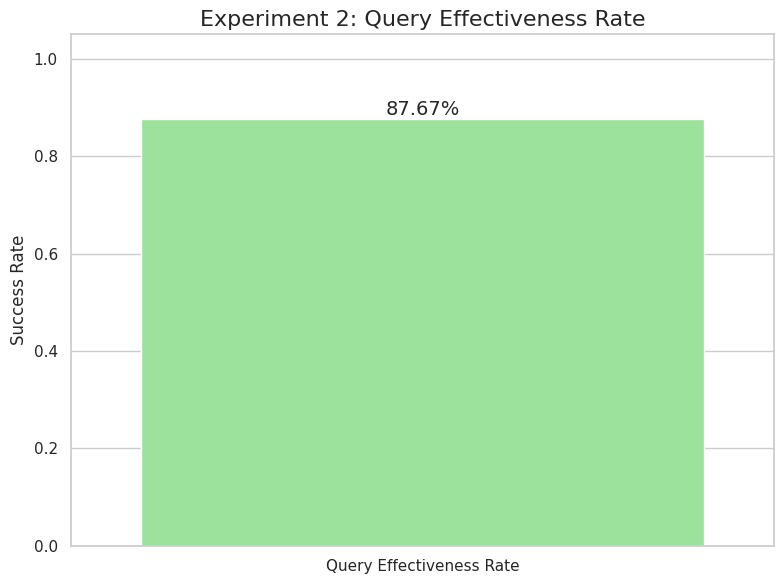

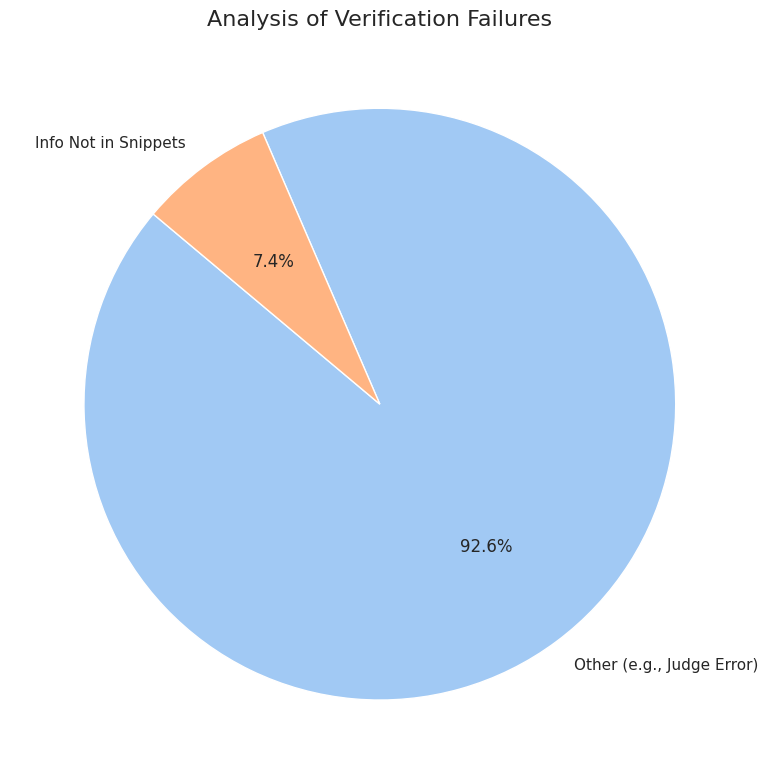

In [18]:
main()